In [27]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from utils.folder import ImageFolder
from utils.common_utils import *
import visdom
import numpy as np

vis = visdom.Visdom()

plt.ion()   # interactive mode

## to start visdom server
sudo /home/yuan/anaconda3/bin/python -m visdom.server


In [28]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5, 0.75], [0.225, 0.225, 0.225,0.225])
    ]),
    'val': transforms.Compose([
#         transforms.Grayscale(num_output_channels=3),
#         transforms.Resize(400),
#         transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5, 0.75], [0.225, 0.225, 0.225, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=1)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [29]:
use_gpu

True

In [30]:
dataset_sizes

{'train': 14, 'val': 1}

In [31]:
# def pil_loader(path):
#     # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
#     with open(path, 'rb') as f:
#         img = Image.open(f)
#         return img.convert('RGB')

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



_inputs.shape= torch.Size([4, 4, 224, 224])
tensor(1.2133) tensor(1.2385) tensor(1.1148) tensor(0.2696)
tensor(0.8584) tensor(0.1315) tensor(-0.2644) tensor(-1.0672)
alphas.shape= torch.Size([4, 1, 224, 224])
1.1111112
-1.1023964
inputs.shape= torch.Size([4, 3, 224, 224])


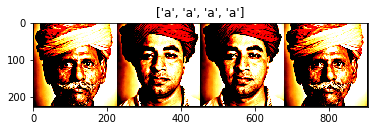

In [32]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
_inputs, classes = next(iter(dataloaders['train']))
print("_inputs.shape=",_inputs.shape)
# Make a grid from batch

inputs = _inputs[:,0:3,:,:]
alphas = _inputs[:,3:4,:,:]
stdr = torch.std(torch.FloatTensor(_inputs[:,0,:,:]))
stdg = torch.std(torch.FloatTensor(_inputs[:,1,:,:]))
stdb = torch.std(torch.FloatTensor(_inputs[:,2,:,:]))
stda = torch.std(torch.FloatTensor(_inputs[:,3,:,:]))

meanr = torch.mean(torch.FloatTensor(_inputs[:,0,:,:]))
meang = torch.mean(torch.FloatTensor(_inputs[:,1,:,:]))
meanb = torch.mean(torch.FloatTensor(_inputs[:,2,:,:]))
meana = torch.mean(torch.FloatTensor(_inputs[:,3,:,:]))

print(stdr,stdg,stdb,stda)
print(meanr,meang,meanb,meana)
print('alphas.shape=',alphas.shape)
print(np.max(alphas.numpy()))
print(np.min(alphas.numpy()))
print("inputs.shape=",inputs.shape)



out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

# img = np_to_pil(alphas[0].numpy())
# img.show() #显示方法之一
# img.save('bb.png')



In [33]:
# vis.image(out,win='in')

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [73]:
def RGBAShow(rgb_np,a_np1=None,a_np2=None,phase = ''):
    if phase == 'val':return
    vis.image(rgb_np,win = phase+'rgb',opts=dict(title=phase+'rgb'))
#     np_to_pil(rgb_np).show()
    if a_np1 is not None:
        #out_np1 = np.concatenate((rgb_np,a_np1),axis=0)
#         out_np1 = rgb_np*a_np1
#         np_to_pil(a_np1).show()
#         vis.image(out_np1,win = phase+'a1',opts=dict(title=phase+'a1'))
        vis.image((-a_np1+1)*128,win = phase+'a1_mask',opts=dict(title=phase+'a1_mask'))
    if a_np2 is not None:
        #out_np2 = np.concatenate((rgb_np,a_np2),axis=0)
#         out_np2 = rgb_np*a_np2
#         vis.image(out_np2,win = phase+'a2',opts=dict(title=phase+'a2'))
        vis.image((-a_np2+1)*128,win = phase+'a2_mask',opts=dict(title=phase+'a2_mask'))
        

In [74]:
def plotLosses():
    plt.plot(all_losses['train'],label='train')
    plt.plot(all_losses['val'],label='val')
    plt.legend()


In [75]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0.0
    all_losses={'train':[],'val':[]}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            
            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs ,labels没有用，只是必须有这层结构
                _inputs, labels = data
                #把alpha通道拆出来，作为label,剩下的作为rgb3通道input
#                 print('_inputs.shape=',_inputs.shape)
                inputs = _inputs[:,0:3,:,:]
                labels = _inputs[:,3:4,:,:]
#                 labels = (labels-0.5)*2
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                #print('outputs mean =',torch.mean(outputs),torch.min(outputs),torch.max(outputs))
                #print('========= outputs===================',outputs[0])
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data.item() * inputs.size(0)
                #show sample
                RGBAShow(inputs.cpu().detach().numpy()[0], a_np1= labels.cpu().detach().numpy()[0], a_np2 = outputs.cpu().detach().numpy()[0],phase = phase)

            epoch_loss = running_loss / dataset_sizes[phase]
            all_losses[phase].append(epoch_loss)
            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'train' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())


            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,all_losses

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [76]:
from models.resnet import ResNet
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'
reg_noise_std = 1./30. # set to 1./20. for sigma=50
OPTIMIZER='adam' # 'LBFGS'
show_every = 500
num_iter=2400
input_depth = 3
figsize = 5 
dtype = (torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)

net = ResNet(3, 1, 8, 32, need_sigmoid=True, act_fun='LeakyReLU')
LR = 0.001


net = net.type(dtype)
# print(net)

In [77]:
# for param in net.parameters():
#     print(type(param.data), param.size())
#     print(param.data)

# s = sum([np.prod(list(p.size())) for p in net.parameters() ])
# print(s)

In [78]:
# weights initializing is far important than you imaging
# learn from inpainting
for n in [x for x in net.parameters()]:
    n.data.normal_()

In [79]:
model_ft = net

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.MSELoss().type(dtype)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [80]:
model_ft,all_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=220)

Epoch 0/219
----------
train Loss: 2.8033
val Loss: 4.0644
Epoch 1/219
----------
train Loss: 2.7759
val Loss: 4.0779
Epoch 2/219
----------
train Loss: 2.7277
val Loss: 3.3734
Epoch 3/219
----------
train Loss: 2.6663
val Loss: 2.8172
Epoch 4/219
----------
train Loss: 2.5924
val Loss: 2.5625
Epoch 5/219
----------
train Loss: 2.5041
val Loss: 2.4095
Epoch 6/219
----------
train Loss: 2.3829
val Loss: 2.2896
Epoch 7/219
----------
train Loss: 2.2938
val Loss: 2.2332
Epoch 8/219
----------
train Loss: 2.2795
val Loss: 2.1956
Epoch 9/219
----------
train Loss: 2.2664
val Loss: 2.1717
Epoch 10/219
----------
train Loss: 2.2517
val Loss: 2.1575
Epoch 11/219
----------
train Loss: 2.2385
val Loss: 2.1415
Epoch 12/219
----------
train Loss: 2.2250
val Loss: 2.1285
Epoch 13/219
----------
train Loss: 2.2113
val Loss: 2.1143
Epoch 14/219
----------
train Loss: 2.2029
val Loss: 2.1117
Epoch 15/219
----------
train Loss: 2.2014
val Loss: 2.1141
Epoch 16/219
----------
train Loss: 2.2003
val Los

KeyboardInterrupt: 

In [ ]:
plotLosses()

In [ ]:
# Show a picture 

# Get a batch of training data
_inputs, classes = next(iter(dataloaders['train']))
print("_inputs.shape=",_inputs.shape)
# Make a grid from batch
inputs = _inputs[:,0:3,:,:]

# print(inputs[0])
inputs_a = _inputs[:,3:4,:,:]
if use_gpu:
    inputs = Variable(inputs.cuda())

model_ft.train(False)    
outs = model_ft(inputs)


In [ ]:
rgb_batch = inputs.cpu().detach().numpy()
np_to_pil(rgb_batch[0]).save('rgb.jpg')

a2_batch = outs.cpu().detach().numpy()
a1_batch = inputs_a.cpu().detach().numpy()
rgba_batch = np.concatenate((rgb_batch,a2_batch),axis=1)

rgba_np=rgba_batch[1]
rgba_pil = np_to_pil(rgba_np)
rgba_pil.show()
rgba_pil.save('rgba.png')



In [47]:
RGBAShow(rgb_batch[0],a_np1=a1_batch[0],a_np2=a2_batch[0])


In [48]:
# def RGBAShowBatch(rgb_np,a_np):
#     out_np = np.concatenate((rgb_np,a_np),axis=1)
#     vis.images(out_np,win='out',opts=dict(caption='out list'),)

# RGBAShowBatch(rgb_batch,a_batch)

In [49]:
np.min(a2_batch)

0.0

In [50]:
np_to_pil(inputs.cpu().detach().numpy()[0]).save('input.jpg')

In [52]:
np_to_pil(ii[0:3,:,:]).save('_input.png')

In [ ]:
model_ft